In [8]:
import os
from typing import Tuple
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision.io.image import read_image


In [18]:
import pandas as pd
import matplotlib.pyplot as plt 

In [10]:
class_counts = pd.read_csv("./datasets/SHIFT/counts_val.csv")

In [11]:
pedestrian_count = class_counts["4"].to_numpy()

In [21]:
class_counts["files"].to_numpy().shape

(25500,)

In [24]:
import json

In [27]:
with open("./datasets/COCO2014/annotations2014/annotations/instances_val2014.json") as f:
    loaded = json.load(f)

In [37]:
from pycocotools.coco import COCO

In [38]:
coco = COCO("./datasets/COCO2014/annotations2014/annotations/instances_val2014.json")

loading annotations into memory...
Done (t=3.64s)
creating index...
index created!


In [43]:
coco.getImgIds()

[391895,
 522418,
 184613,
 318219,
 554625,
 397133,
 574769,
 60623,
 309022,
 5802,
 222564,
 118113,
 193271,
 224736,
 483108,
 403013,
 374628,
 328757,
 384213,
 293802,
 86408,
 37777,
 372938,
 386164,
 223648,
 204805,
 113588,
 384553,
 337264,
 368402,
 12448,
 252219,
 79841,
 87038,
 174482,
 515289,
 562150,
 542145,
 412151,
 403385,
 579003,
 540186,
 242611,
 51191,
 269105,
 294832,
 462565,
 144941,
 173350,
 60760,
 324266,
 166532,
 262284,
 360772,
 6818,
 191381,
 111076,
 340559,
 258985,
 509822,
 321107,
 229643,
 125059,
 455483,
 436141,
 129001,
 232262,
 61181,
 166323,
 580041,
 326781,
 387362,
 138079,
 556616,
 472621,
 192440,
 86320,
 256668,
 383445,
 565797,
 81922,
 50125,
 364521,
 394892,
 1146,
 310391,
 97434,
 463836,
 241876,
 156832,
 480985,
 458054,
 270721,
 462341,
 310103,
 32992,
 122851,
 540763,
 331352,
 138246,
 197254,
 32907,
 251252,
 37675,
 159537,
 268556,
 271177,
 75051,
 549399,
 85160,
 559665,
 296649,
 19358,
 459912,

In [47]:
img = coco.imgs[74]


In [50]:
img["file_name"]

'COCO_val2014_000000000074.jpg'

In [45]:
from PIL import Image

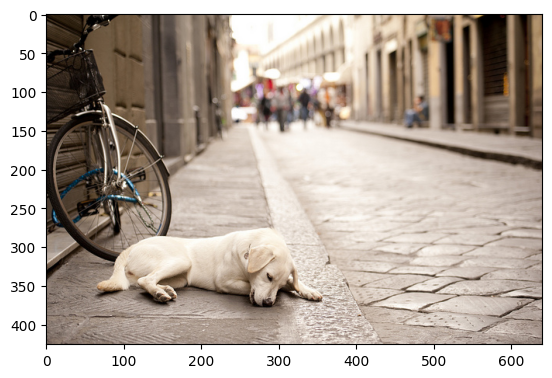

In [53]:
plt.imshow(Image.open(os.path.join("./datasets/COCO2014/val2014/val2014", img["file_name"])))

In [54]:
cat_ids = coco.getCatIds()

In [62]:
anns

[]

In [57]:
anns_id = coco.getAnnIds(imgIds=img["id"], catIds=cat_ids, iscrowd=None)

In [58]:
anns_id

[1774, 128367, 195946, 253933, 1225755, 1733076, 1747768, 1751664]

In [63]:
anns = coco.loadAnns(anns_id)

In [69]:
mask = coco.annToMask(anns[1])

In [70]:
mask.max()

1

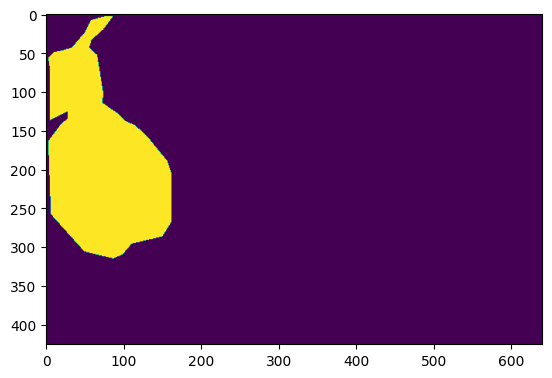

In [71]:
plt.imshow(mask)

In [17]:
class_counts["files"].to_numpy()[np.argwhere((pedestrian_count > 10000) & (pedestrian_count < 15000))]

array([['discrete/images/val/front/semseg/818f-6c2e/00000050_semseg_front.png'],
       ['discrete/images/val/front/semseg/ab2f-4a49/00000480_semseg_front.png'],
       ['discrete/images/val/front/semseg/ab2f-4a49/00000070_semseg_front.png'],
       ...,
       ['discrete/images/val/front/semseg/55cf-b962/00000120_semseg_front.png'],
       ['discrete/images/val/front/semseg/ef2e-a95b/00000290_semseg_front.png'],
       ['discrete/images/val/front/semseg/ef2e-a95b/00000300_semseg_front.png']],
      dtype=object)

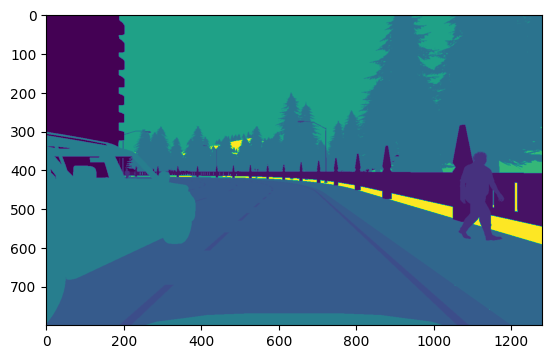

In [20]:
plt.imshow(read_image('./datasets/SHIFT/discrete/images/val/front/semseg/818f-6c2e/00000050_semseg_front.png')[0])